In [47]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as scs
import scipy.special as scl
import scipy.integrate as spint
import scipy.interpolate as spinterp
import scipy.fft as scft
import scipy.stats as scst
import lmfit as lm

<h2>Functions</h2>

In [2]:
def purefringes(y_detector,parameters, delta_p=0, printvals = False):
    """
    This function calculates the fringe pattern for given parameters and detector y coordinates. 
    This function does not take into account the fresnel diffraction effect from the slats.
    """
    # baseline_len, theta_offaxis, theta_b, beam_width, L, wavelength,
    # parameters = {'baseline_len':10, 'theta_offaxis':0, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

    # Define required values from dict
    baseline_len = parameters['baseline_len']
    theta_offaxis = parameters['theta_offaxis']
    beam_width = parameters['beam_width']
    L = parameters['L']
    theta_b = parameters['beam_width'] / parameters['L']
    wavelength = parameters['wavelength']
    
    # y_0 is the central point of the fringes on the detector.
    y_0 = -baseline_len * np.sin(theta_offaxis) / (2 * np.sin(theta_b/2)) + delta_p
    # Re-define coordinate system such that y_prime is 0 for the central fringe
    y_prime = y_detector - y_0

    # Define fresnel variables
    u = y_prime * np.sqrt(2/(wavelength * L))
    u_0 = beam_width * np.sqrt(2/(wavelength * L))

    # Define fringe amplitudes based on fresnel variables
    fringe_amp = 1 + np.exp(1j * u * u_0 * np.pi)
    fringe_spacing = wavelength/theta_b

    if printvals:
        
        # print(f'The expected fringe spacing is {fringe_spacing:.2e} m')
        # print(f'The expected centre of the fringes is at {y_0:.2e} m')
        pass

    return fringe_amp, fringe_spacing, y_0, y_prime

def fresnel_diff(y_detector, parameters, delta_p=0, printvals = False):
    """
    Calculates the fresnel diffraction pattern for given set of parameters
    """

    # Define required values from dict
    baseline_len = parameters['baseline_len']
    theta_offaxis = parameters['theta_offaxis']
    beam_width = parameters['beam_width']
    L = parameters['L']
    theta_b = parameters['beam_width'] / parameters['L']
    wavelength = parameters['wavelength']
    
    y_0 = -L * theta_offaxis
    y_prime = y_detector - y_0
    # Define fresnel variables
    u = y_prime * np.sqrt(2/(wavelength * L))
    u_0 = beam_width * np.sqrt(2/(wavelength * L))

    # Define fringe amplitudes based on fresnel variables
    fringe_amp = 1 + np.exp(1j * u * u_0 * np.pi)
    fringe_spacing = wavelength/theta_b

    u_1 = u - u_0/2
    u_2 = u + u_0/2
    
    C_1, S_1 = scl.fresnel(u_1)
    # print('Integral',C_1)
    C_2, S_2 = scl.fresnel(u_2)

    # print(C_1, S_2)

    A = C_2 - C_1 + 1j*(S_2 - S_1)
    # plt.plot(np.abs(A)**2)
    # plt.show()
    

    if printvals:
        
        # print(f'The expected fringe spacing is {fringe_spacing:.2e} m')
        # print(f'The expected centre of the fringes is at {y_0:.2e} m')
        pass

    return A, y_prime, y_0

In [3]:
def calc_single(y_val, parameters, delta_p=0):
    """
    Calculates the amplitude for a single given y-axis position.
    """

    # Define required values from dict
    baseline_len = parameters['baseline_len']
    theta_offaxis = parameters['theta_offaxis']
    beam_width = parameters['beam_width']
    L = parameters['L']
    theta_b = parameters['beam_width'] / parameters['L']
    wavelength = parameters['wavelength']
    
    # Fringe Pattern
    y_0 = -baseline_len * np.sin(theta_offaxis) / (2 * np.sin(theta_b/2)) + delta_p
    y_prime = y_val - y_0

    # Define fresnel variables
    u = y_prime * np.sqrt(2/(wavelength * L))
    u_0 = beam_width * np.sqrt(2/(wavelength * L))

    # Define fringe amplitudes based on fresnel variables
    A_fringe = 1 + np.exp(1j * u * u_0 * np.pi)
    fringe_spacing = wavelength/theta_b
    
    
    # Fresnel Diffraction
    y_0 = -L * theta_offaxis
    y_prime = y_val - y_0
    # Define fresnel variables
    u = y_prime * np.sqrt(2/(wavelength * L))
    u_0 = beam_width * np.sqrt(2/(wavelength * L))

    # Define fringe amplitudes based on fresnel variables
    fringe_amp = 1 + np.exp(1j * u * u_0 * np.pi)
    fringe_spacing = wavelength/theta_b

    u_1 = u - u_0/2
    u_2 = u + u_0/2
    
    C_1, S_1 = scl.fresnel(u_1)
    # print('Integral',C_1)
    C_2, S_2 = scl.fresnel(u_2)

    # print(C_1, S_2)

    A_fresnel = C_2 - C_1 + 1j*(S_2 - S_1)

    A_full = A_fresnel * A_fringe
    return A_full

In [4]:
def GenerateSamples(sample_size, parameters, ret_ph_count = False, vary_P = False, delta_P_inp = 0):
    """
    Generates a given number of samples based on parameters specified. 
    Returns accepted/rejected y coords as well as the corresponding intensity values. If ret_ph_count = True, also returns the 
    total number of accepted photons.
    """
    
    y_detector_max = 0.0003 # y coordinate max (min = -max) for the detector
    y = np.linspace(-y_detector_max, y_detector_max, 5000) # This is very high resolution - we will re-bin this when doing the fourier transforms based on the detector

    # Calculate Max of I based on max at theta=0, delta_P = 0
    delta_P = 0
    A_pure, fringe_spacing, center_pure, y_prime = purefringes(y, parameters, delta_P)
    A_fresnel, y_prime, center_f = fresnel_diff(y, parameters, delta_P)
    
    A_full = A_pure * A_fresnel
    I = np.abs(A_full)**2
    I_max = np.max(I)
    
    # ----------------
    # Sampling
    # ----------------
    
    size_samples = sample_size # The number of samples taken per readout

    # Sample y pixel coord and I value using y_max and I_max resepctively
    y_sample = np.random.uniform(size = size_samples) * y_detector_max * 2 - y_detector_max
    I_sample = np.random.uniform(size = size_samples) * I_max
    
    # Initialize Arrays
    accepted_y = np.array([])
    rejected_y = np.array([])
    accepted_I = np.array([])
    rejected_I = np.array([])

    # Generate Samples
    y_sample = np.random.uniform(size = 1) * y_detector_max * 2 - y_detector_max
    I_sample = np.random.uniform(size = 1) * I_max

    n_accepted = 0
    accept_rate = 0.2 # Can change this value if needed

    # We are generating samples based on the acceptance rate 
    # this speeds up the code significantly by having the while loop run for fewer iterations
    
    while n_accepted < sample_size:
        # Generate a large number of samples based on how many more we need:
        n_samples = int((sample_size - n_accepted) / accept_rate)
        to_accept = sample_size - n_accepted
        if vary_P:
            delta_P = np.ones(shape = n_samples) * delta_P_inp
        else:
            delta_P = np.random.uniform(size = n_samples) * 0
            
    
        y_sample = np.random.uniform(size = n_samples) * y_detector_max * 2 - y_detector_max
        I_sample = np.random.uniform(size = n_samples) * I_max
        I_true = np.abs(calc_single(y_sample, parameters, delta_P))**2

        accepted_y_temp, accepted_I_temp = y_sample[I_sample <= I_true], I_sample[I_sample <= I_true]
        rejected_y_temp, rejected_I_temp = y_sample[I_sample > I_true], I_sample[I_sample > I_true]
        if len(accepted_y_temp) < to_accept:
        # print(accepted_y_temp)
            accepted_y = np.append(accepted_y, accepted_y_temp)
            accepted_I = np.append(accepted_I, accepted_I_temp)
            rejected_y = np.append(rejected_y, rejected_y_temp)
            rejected_I = np.append(rejected_I, rejected_I_temp)
        else:
            accepted_y = np.append(accepted_y, accepted_y_temp[:to_accept])
            accepted_I = np.append(accepted_I, accepted_I_temp[:to_accept])
            rejected_y = np.append(rejected_y, rejected_y_temp)
            rejected_I = np.append(rejected_I, rejected_I_temp)
        
        n_accepted = len(accepted_y)
        
    
    if not ret_ph_count:
        return accepted_y, accepted_I, rejected_y, rejected_I
    else:
        return accepted_y, accepted_I, rejected_y, rejected_I, n_accepted

# Generating a Complete Fringe Pattern

By setting a very large number of photons to be generated, we can look at how the fringe pattern varies for different parameters. Here, we look at how changing the off-axis angle affects the fringe pattern

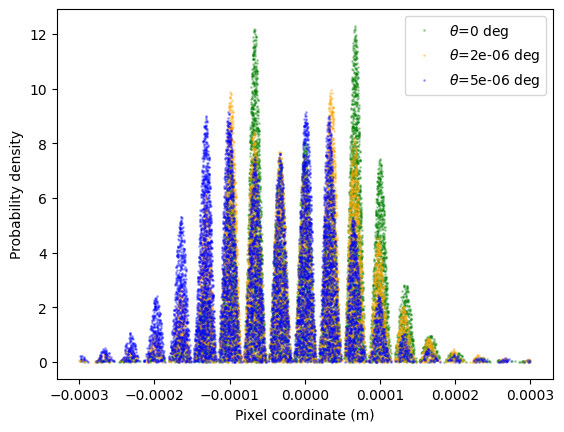

In [5]:
parameters = {'baseline_len':10, 'theta_offaxis':0, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

accepted_y, accepted_I, rejected_y, rejected_I = GenerateSamples(10000, parameters)
plt.plot(accepted_y, accepted_I, '.', color='green', markersize=2, alpha=.3, label = fr'$\theta$={parameters["theta_offaxis"]} deg')

parameters = {'baseline_len':10, 'theta_offaxis':2e-6, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

accepted_y, accepted_I, rejected_y, rejected_I = GenerateSamples(10000, parameters)
plt.plot(accepted_y, accepted_I, '.', color='orange', markersize=2, alpha=.3, label = fr'$\theta$={parameters["theta_offaxis"]} deg')

parameters = {'baseline_len':10, 'theta_offaxis':5e-6, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

accepted_y, accepted_I, rejected_y, rejected_I = GenerateSamples(10000, parameters)
plt.plot(accepted_y, accepted_I, '.', color='blue', markersize=2, alpha=.3, label = fr'$\theta$={parameters["theta_offaxis"]} deg')

plt.xlabel('Pixel coordinate (m)')
plt.ylabel('Probability density')

plt.legend()
plt.savefig('FringePattern.png')
plt.show()

# Fourier Transforms


In [10]:
plt.close()
# parameters = {'baseline_len':1, 'theta_offaxis':0, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}
def wrapper(parameters = {'baseline_len':10, 'theta_offaxis':0, 'beam_width':300e-6, 'L':10, 
                          'wavelength':10e-10}, ph_count_rate = 20, t_exp = 0.003, T_max = 1000, max_readout = 24, save_dir='', plot=False, save_plots=False):
    """
    Runs a single 'experiment'. This involves taking a calculated number of 'exposures' that simulates exposures from a CCD. The periodogram obtained
    from each of these exposures is then stacked and normalized using fractional rms normalization. This is then plotted.
    
    """
    # Define poisson count rate based on exposure time
    count_rate = t_exp * ph_count_rate

    # Ensure that the max readout rate is not exceeded
    if 1 / t_exp > max_readout:
        readout_rate = max_readout
    else:
        readout_rate = 1/t_exp

    # Calculate the required number of exposures to achieve integration time
    n_exp = int(T_max * readout_rate) # Number of exposures that correspond to the integration time
    
    yf_list = []
    accepted_photons = []
    # print('Number of exposures to be taken:', n_exp)

    # Genarate number of photons that are recorded per exposure using a Poisson distribution
    n_ph_per_exp = scst.poisson.rvs(count_rate, size=n_exp)
    
    for i in range(n_exp):

        # Do the calculations only if we have >1 photons in the exposure
        if n_ph_per_exp[i] != 0:
            delta_P = np.random.uniform(size = 1) * 1e-2 # Adding random path length variations in between exposures
            accepted_y, accepted_I, rejected_y, rejected_I, n_ph = GenerateSamples(n_ph_per_exp[i], parameters, vary_P = True, ret_ph_count = True, delta_P_inp = delta_P)
            accepted_photons.append(n_ph)
            
            # Defining the grid of pixels on the detector
            # Resolution given by 
            y_detector_max = 0.0003
            n_bins = 600
            spacing = (2 * y_detector_max) / n_bins
            bins_y = np.linspace(-y_detector_max, -y_detector_max + spacing * n_bins, n_bins, endpoint=True)

            # Creating histogram based on detector bins
            counts, edges = np.histogram(accepted_y, bins=bins_y)
            
            
            # Define Fourier Frequencies:
            N = len(edges) - 1 # Number of bins
            min_freq = 1/N
            max_freq = 1/2 * (1/N)
            
            # Do the Fourier Transform
            yf = scft.fft(counts)
            
            # Normalize
            yf = np.abs(yf)**2
            yf_list.append(yf)
            
            # Define the corresponding frequencies
            xf = scft.fftfreq(N, edges[1]-edges[0])
    
    yf_list = np.array(yf_list)
    sum_yf = np.sum(yf_list, axis=0)
    tot_accepted_ph = np.sum(accepted_photons)
    
    norm_yf = 2 * (n_bins / tot_accepted_ph**2) * sum_yf
    P_noise = 2 * n_bins / tot_accepted_ph
    
    val = np.argsort(sum_yf)[-4]-1
    val_2 = 0
    sigma = P_noise / np.sqrt(n_exp)
    
    one_sigma_int = P_noise + 1 * sigma
    two_sigma_int = P_noise + 2 * sigma
    three_sigma_int = P_noise + 3 * sigma


    # Searching for 3-sigma detections
    expected_freq = 30000
    tolerance = spacing / expected_freq

    freq_spacing = xf[1] - xf[0]

    significant_freqs = xf[norm_yf > three_sigma_int]
    significant_freqs = significant_freqs[np.abs(significant_freqs - expected_freq) <= freq_spacing]
    
    #Testing
    # print(xf[1:]-xf[:-1])
    selected_pow = norm_yf[np.abs(xf - expected_freq) <= freq_spacing]
    sig_val = np.abs(selected_pow - P_noise) / sigma
    if len(sig_val)>1:
        sig_val = np.max(sig_val)
    # print(sig_val)
    
    sig_detection = False
    
    if len(significant_freqs)>=1:
        sig_detection = True
        # print('Success')

    if plot:
        [plt.axvline(x, linestyle='dotted', color='red', label=fr'>3-$\sigma$ detections') for x in significant_freqs]
        
        plt.plot(xf[xf>0], norm_yf[xf>0])
        plt.axhline(P_noise, linestyle='dotted', color='black', label='Noise Level')
        plt.axhline(three_sigma_int, linestyle='dotted', color='grey', label='Three Sigma Level')
        plt.ylabel('Normalized Power')
        plt.xlabel('Spatial Frequency')
        plt.legend()
        plt.savefig(f'{save_dir}NormalizedPowerSpectrum_run{run_num}_{t_exp}texp_{T_max}Tmax_{ph_count_rate}photoncountrate.png', dpi=300)

    if save_plots:
        # !! Note that run_num is defined outside the funtion !!
        name=f'{save_dir}PeriodogramArrays_{t_exp}texp_{T_max}Tmax_{run_num}'
        np.savez(name, xf, norm_yf)

    return sig_detection, sig_val

## Testing

In [23]:
# Define parameters for the setup
# All values are defined in SI units
parameters = {'baseline_len':10, 'theta_offaxis':0, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}
run_num = 1
# Define experimental parameters for a given run
ph_count_rate = 50 # Expected count rate in photons/s
t_exp = 0.001 # Time interval for one exposure in s
T_max = 50 # Run time in s
max_readout = 24 # Readout rate limit set by camera (in readouts/s)
save_dir='' # Directory to save results in, set to '' for current directory
# sig_det, sig_val = wrapper(parameters = parameters, ph_count_rate=ph_count_rate, t_exp=t_exp, T_max=T_max, max_readout=max_readout, 
#                           save_dir=save_dir, plot=True, save_plots=True)
# print(sig_det, sig_val)

<h1>Sample Experimental Run</h1>

In [32]:
# Define parameters for the setup
# All values are defined in SI units
parameters = {'baseline_len':10, 'theta_offaxis':0, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10} # These are always going to be fixed
sig_val_list = []
# Define experimental parameters for a given run
ph_count_rate = 20 # Expected count rate in photons/s
t_exp = 0.005 # Time interval for one exposure in s
# T_max = 400 # Maximum integration time in s
max_readout = 24 # Readout rate limit set by camera (in readouts/s)

sig_val_avg_list = []
sig_val_std_err_list = []

for T_max in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1500, 2000]:
    print('Currently running T max =', T_max)
    save_dir='Results/Final 2/' # Directory to save results in, do not include as an arg if current directory (or set to './')
    
    n_exp_runs = 50
    
    run_num = 1
    counter=0
    sig_val_list = []
    
    for j in range(n_exp_runs):
        plt.close()
        sig_det, sig_val = wrapper(parameters = parameters, ph_count_rate=ph_count_rate, t_exp=t_exp, T_max=T_max, max_readout=max_readout, 
                          save_dir=save_dir, plot=False, save_plots=True)
        sig_val_list.append(sig_val)
        
        if sig_det:
            counter+=1
        run_num += 1
    
    sig_val_list = np.array(sig_val_list)
    sig_val_avg = np.mean(sig_val_list)
    sig_val_avg_list.append(sig_val_avg)
    
    sig_val_std = np.std(sig_val_list)
    sig_val_std_err = sig_val_std / np.sqrt(len(sig_val_list))
    sig_val_std_err_list.append(sig_val_std_err)
        
    print(f'For exposure time={t_exp} and integration time {T_max}: {counter}/{n_exp_runs} | Average sig level: {sig_val_avg:.2f} ± {sig_val_std_err:.2f}')

Currently running T max = 100
For exposure time=0.005 and integration time 100: 2/50 | Average sig level: 1.65 ± 0.11
Currently running T max = 200
For exposure time=0.005 and integration time 200: 4/50 | Average sig level: 1.66 ± 0.13
Currently running T max = 300
For exposure time=0.005 and integration time 300: 10/50 | Average sig level: 2.37 ± 0.13
Currently running T max = 400
For exposure time=0.005 and integration time 400: 14/50 | Average sig level: 2.56 ± 0.13
Currently running T max = 500
For exposure time=0.005 and integration time 500: 26/50 | Average sig level: 2.98 ± 0.14
Currently running T max = 600
For exposure time=0.005 and integration time 600: 22/50 | Average sig level: 2.95 ± 0.13
Currently running T max = 700
For exposure time=0.005 and integration time 700: 30/50 | Average sig level: 3.04 ± 0.14
Currently running T max = 800
For exposure time=0.005 and integration time 800: 36/50 | Average sig level: 3.50 ± 0.11
Currently running T max = 900
For exposure time=0.

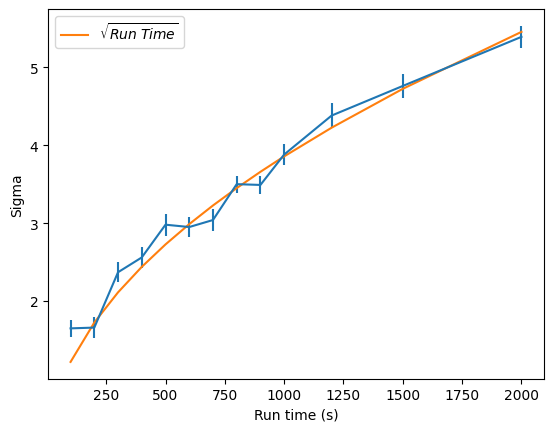

In [33]:
run_times = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1500, 2000])

result_sigvals = [1.65, 1.66, 2.37, 2.56, 2.98, 2.95, 3.04, 3.50, 3.49, 3.88, 4.38, 4.76, 5.39]
result_errs = [0.11, 0.13, 0.13, 0.13, 0.14, 0.13, 0.14, 0.11, 0.11, 0.13, 0.16, 0.15, 0.14]

plt.errorbar(run_times, result_sigvals, yerr=result_errs)

M = run_times/0.005

# snr = sig_val_avg_list + M
# plt.plot(snr, M, '.')

plt.plot(run_times, np.sqrt(run_times)/8.2, label=r'$\sqrt{Run \; Time}$')
# plt.plot(M, result_sigvals)
plt.xlabel('Run time (s)')
plt.ylabel('Sigma')
plt.savefig('Figures/RunTime_Scaling.png')
plt.legend()


ValueError: x and y must have same first dimension, but have shapes (13,) and (10,)

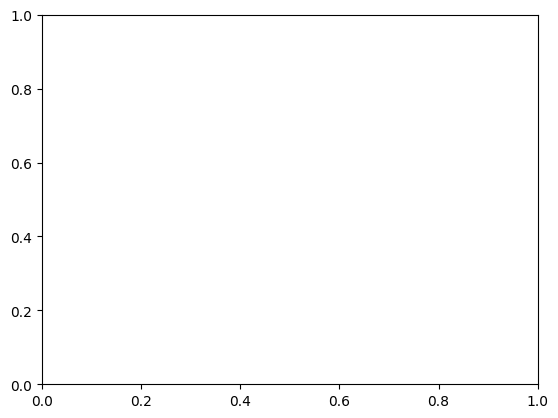

In [8]:
result_list = [1, 3, 7, 21, 17, 20, 32, 32, 37, 43]
sig_list = [1.29, 1.90, 2.03, 2.36, 3.25, 2.79, 3.36, 3.26, 3.98, 3.95]
errs = [0.13, 0.16, 0.20, 0.17, 0.21, 0.19, 0.16, 0.19]
T_max_list = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1500, 2000])

plt.plot(T_max_list, sig_list, '+')
plt.plot(T_max_list, np.sqrt(T_max_list)/8)

plt.ylabel('Number of significant detections out of 50')
plt.xlabel('Total integration time (s)')

plt.savefig('SigDetvsIntTime.png')

## Noise Verification - Ignore

In [21]:
def noise_wrapper(parameters = {'baseline_len':1, 'theta_offaxis':0, 'beam_width':300e-6, 'L':10, 
                          'wavelength':10e-10}, ph_count_rate = 20, t_exp = 0.003, T_max = 1000, max_readout = 24, save_dir='', plot=True):
    """
    Runs a single 'experiment'. This involves taking a calculated number of 'exposures' that simulates exposures from a CCD. The periodogram obtained
    from each of these exposures is then stacked and normalized using fractional rms normalization. This is then plotted.
    
    """
    # Define poisson count rate based on exposure time
    count_rate = t_exp * ph_count_rate

    # Ensure that the max readout rate is not exceeded
    if 1 / t_exp > max_readout:
        readout_rate = max_readout
    else:
        readout_rate = 1/t_exp

    # Calculate the required number of exposures to achieve integration time
    n_exp = int(T_max * readout_rate) # Number of exposures that correspond to the integration time
    
    yf_list = []
    accepted_photons = []
    print('Number of exposures to be taken:', n_exp)

    # Genarate number of photons that are recorded per exposure using a Poisson distribution
    n_ph_per_exp = scst.poisson.rvs(count_rate, size=n_exp)
    
    for i in range(n_exp):

        # Do the calculations only if we have >1 photons in the exposure
        if n_ph_per_exp[i] != 0:
            delta_P = np.random.uniform(size = 1) * 1e-2 # Adding random path length variations in between exposures
            accepted_y, accepted_I, rejected_y, rejected_I, n_ph = GenerateSamples(n_ph_per_exp[i], parameters, vary_P = True, ret_ph_count = True, delta_P_inp = delta_P)
            accepted_photons.append(n_ph)
            
            # Defining the grid of pixels on the detector
            # Resolution given by 
            y_detector_max = 0.0003
            n_bins = 600
            spacing = (2 * y_detector_max) / n_bins
            bins_y = np.linspace(-y_detector_max, -y_detector_max + spacing * n_bins, n_bins, endpoint=True)

            # Creating histogram based on detector bins
            counts, edges = np.histogram(accepted_y, bins=bins_y)
            
            
            # Define Fourier Frequencies:
            N = len(edges) - 1 # Number of bins
            min_freq = 1/N
            max_freq = 1/2 * (1/N)
            
            # Do the Fourier Transform
            yf = scft.fft(counts)
            
            # Normalize
            yf = np.abs(yf)**2
            yf_list.append(yf)
            
            # Define the corresponding frequencies
            xf = scft.fftfreq(N, edges[1]-edges[0])
    
    yf_list = np.array(yf_list)
    sum_yf = np.sum(yf_list, axis=0)
    tot_accepted_ph = np.sum(accepted_photons)
    
    norm_yf = 2 * (n_bins / tot_accepted_ph**2) * sum_yf
    P_noise = 2 * n_bins / tot_accepted_ph
    
    val = np.argsort(sum_yf)[-4]-1
    val_2 = 0
    sigma = P_noise / np.sqrt(n_exp)
    print(sigma)
    one_sigma_int = P_noise + 1 * sigma
    two_sigma_int = P_noise + 2 * sigma
    three_sigma_int = P_noise + 3 * sigma

    avg_noise = np.mean(norm_yf[xf>31000])
    print(avg_noise)
    print(P_noise)
    
    # Searching for 3-sigma detections
    expected_freq = 30000
    tolerance = spacing / expected_freq

    significant_freqs = xf[norm_yf > three_sigma_int]
    significant_freqs = significant_freqs[np.abs(significant_freqs - expected_freq) <= tolerance*expected_freq]
    
    sig_detection = False
    if len(significant_freqs)>=1:
        sig_detection = True
        print('Success')

    if plot:
        # [plt.axvline(x, linestyle='dotted', color='red', label=fr'>3-$\sigma$ detections') for x in significant_freqs]
        
        plt.plot(xf[xf>0], norm_yf[xf>0])
        # plt.plot(xf, sum_yf)
        # plt.axvline(30000, linestyle='dotted', color='grey')
        # plt.axvline(-30000, linestyle='dotted', color='grey')
        plt.axhline(P_noise, linestyle='dotted', color='black', label='Noise Level')
        plt.axhline(three_sigma_int, linestyle='dotted', color='grey', label='Three Sigma Level')
        # plt.axhline(two_sigma_int, linestyle='dotted', color='grey')
        # plt.axhline(one_sigma_int, linestyle='dotted', color='grey')
        plt.ylabel('Normalized Power')
        plt.xlabel('Spatial Frequency (m$^{-1}$)')
        plt.legend()
        plt.savefig('NoiseLevel.png')

Number of exposures to be taken: 24000
0.0032194375280194657
0.49836261337876664
0.49875311720698257
Success


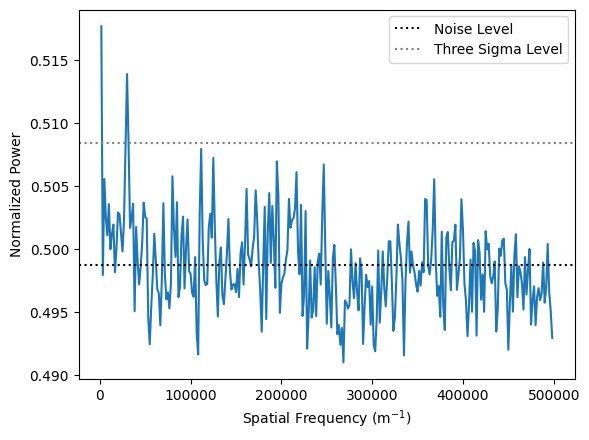

In [22]:
ph_count_rate = 20 # Expected count rate in photons/s
t_exp = 0.005 # Time interval for one exposure in s
T_max = 1000 # Maximum integration time in s
max_readout = 24 # Readout rate limit set by camera (in readouts/s)
save_dir = ''
sig_det = noise_wrapper(parameters = parameters, ph_count_rate=ph_count_rate, t_exp=t_exp, T_max=T_max, max_readout=max_readout, 
                      save_dir=save_dir, plot=True)

# Running the Code
Use the cell below to run the code.<br>
The experimental parameters can be changed in the 'setup_parameters' dictionary as well as by changing the variables ph_count_rate, t_exp, T_max and max_readout.<br>
Note that the parameter L is the same as in the Willingale paper.<br>
The code will output all the generated plots to the specified directory.

Run 0 complete
Run 1 complete
Run 2 complete
Run 3 complete
Run 4 complete
Run 5 complete
Run 6 complete
Run 7 complete
Run 8 complete
Run 9 complete
Run 10 complete
Run 11 complete
Run 12 complete
Run 13 complete
Run 14 complete
Run 15 complete
Run 16 complete
Run 17 complete
Run 18 complete
Run 19 complete
Run 20 complete
Run 21 complete
Run 22 complete
Run 23 complete
Run 24 complete
For exposure time=0.001 and integration time 50000: 24/25 | avg sigma = 5.653955176736921 ± 0.215223416138025


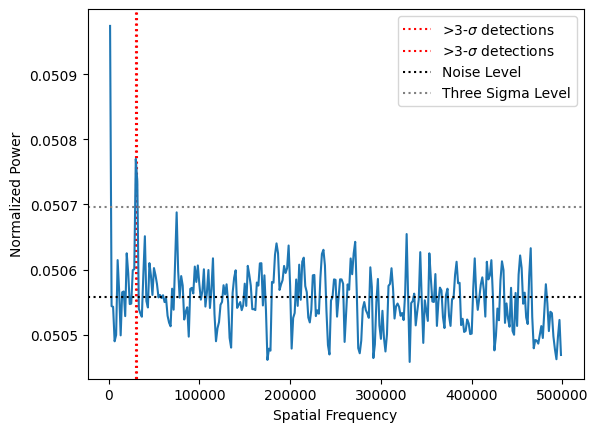

In [74]:
# Define experimental parameters for a given run
setup_parameters = {'baseline_len':10, 'theta_offaxis':0, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

ph_count_rate = 20 # Expected count rate in photons/s
t_exp = 0.001 # Time interval for one exposure in s
T_max = 50000 # Maximum integration time in s
max_readout = 24 # Readout rate limit set by camera (in readouts/s)

save_dir='' # Directory to save results in, do not include as an arg if current directory (or set to './')

n_exp_runs = 25 # Sets the number of experiments to be run

#Initialize
run_num = 1
counter=0
avg_sig_val = 0

sig_val_avg_list = []
sig_val_std_err_list = []
sig_val_list = []

for j in range(n_exp_runs):
    plt.close()
    sig_det, sig_val = wrapper(parameters = setup_parameters, ph_count_rate=ph_count_rate, t_exp=t_exp, T_max=T_max, max_readout=max_readout, 
                      save_dir=save_dir, plot=True, save_plots=False)
    sig_val_list.append(sig_val)
    
    if sig_det:
        counter+=1
    run_num += 1
    print(f'Run {j} complete')

sig_val_list = np.array(sig_val_list)
sig_val_avg = np.mean(sig_val_list)


sig_val_std = np.std(sig_val_list)
sig_val_std_err = sig_val_std / np.sqrt(len(sig_val_list))


print(f'For exposure time={t_exp} and integration time {T_max}: {counter}/{n_exp_runs} | avg sigma = {sig_val_avg} ± {sig_val_std_err}')

# Fixed run time, varying exposure times

For exposure time=0.001 and integration time 8000: 10/50 | avg sigma = 2.2972931966202577 ± 1.00
For exposure time=0.002 and integration time 8000: 45/50 | avg sigma = 4.583345950649203 ± 1.09
For exposure time=0.004 and integration time 8000: 50/50 | avg sigma = 8.74040984067667 ± 1.05
For exposure time=0.006 and integration time 8000: 50/50 | avg sigma = 13.301139512966436 ± 0.91
For exposure time=0.007 and integration time 8000: 50/50 | avg sigma = 15.235334234157564 ± 0.98
For exposure time=0.009 and integration time 8000: 50/50 | avg sigma = 19.60348703012382 ± 0.88
For exposure time=0.01 and integration time 8000: 50/50 | avg sigma = 21.758720742860195 ± 1.02


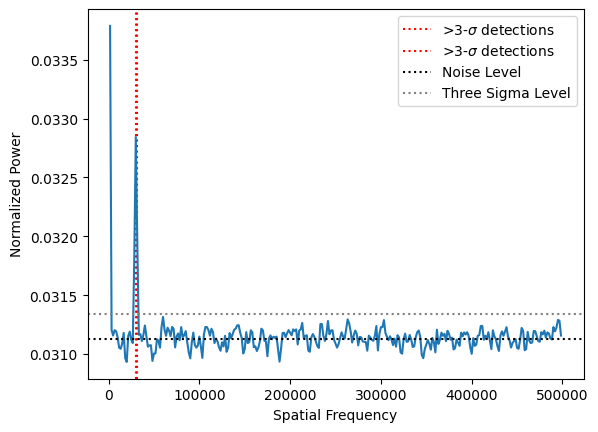

In [22]:
setup_parameters = {'baseline_len':10, 'theta_offaxis':0, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

ph_count_rate = 20 # Expected count rate in photons/s
# t_exp = 0.5 # Time interval for one exposure in 
T_max = 8000 # Maximum integration time in s
max_readout = 24 # Readout rate limit set by camera (in readouts/s)

save_dir='Results/Set 12/' # Directory to save results in, do not include as an arg if current directory (or set to './')

n_exp_runs = 50 # Sets the number of experiments to be run
t_exps = [0.001, 0.002, 0.004, 0.006, 0.007, 0.009, 0.010]

avg_sig_val_list = []
sig_val_std_list = []
for t_exp in t_exps:
    #Initialize
    
    run_num = 1
    counter=0
    avg_sig_val = 0

    sig_val_list = []

    for j in range(n_exp_runs):
        plt.close()
        sig_det, sig_val = wrapper(parameters = setup_parameters, ph_count_rate=ph_count_rate, t_exp=t_exp, T_max=T_max, max_readout=max_readout, 
                          save_dir=save_dir, plot=True, save_plots=False)
        
    
        sig_val_list.append(sig_val)
        if sig_det:
            counter+=1
        run_num += 1
    
    avg_sig_val = np.mean(sig_val_list)
    sig_val_std = np.std(sig_val_list)
    
    avg_sig_val_list.append(avg_sig_val)
    sig_val_std_list.append(sig_val_std)
    print(f'For exposure time={t_exp} and integration time {T_max}: {counter}/{n_exp_runs} | avg sigma = {avg_sig_val} ± {sig_val_std:.2f}')

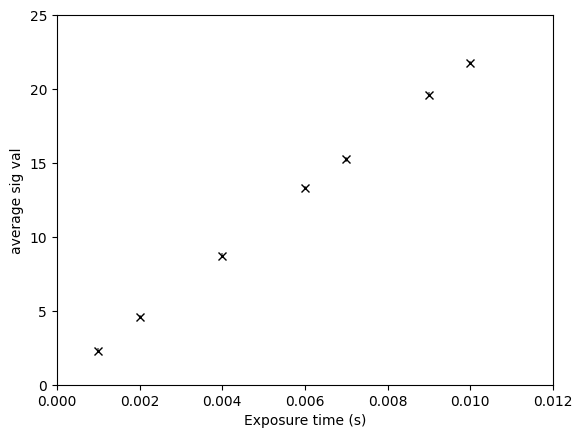

In [46]:
plt.errorbar(t_exps, avg_sig_val_list, yerr=sig_val_std/np.sqrt(50), ecolor='grey', fmt='kx')

plt.xlabel('Exposure time (s)')
plt.ylabel('average sig val')

plt.xlim(0, 0.012)
plt.ylim(0, 25)

plt.savefig('Figures/sigval_vs_texp.png')

In [76]:
mod = lm.models.LinearModel()
# help(mod)

x = np.array(t_exps)
y = np.array(avg_sig_val_list)
pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

In [95]:
x = np.array(t_exps)
y = np.array(avg_sig_val_list)
yerr = np.array(sig_val_std_list) / np.sqrt(50)
def residual(params, xdat, ydat, yerrs):
    y_mod = mod.eval(params=params, x=x)
    resid = (y_mod - ydat) / yerrs
    # print(resid)
    return resid
minimizer = lm.Minimizer(residual, pars, fcn_args=(x, y, yerr))
res = minimizer.minimize()
print(res.params)
lm.report_fit(res)

Parameters([('slope', <Parameter 'slope', value=2158.1682799207397 +/- 11.9, bounds=[-inf:inf]>), ('intercept', <Parameter 'intercept', value=0.1962846872935532 +/- 0.0785, bounds=[-inf:inf]>)])
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 7
    # variables        = 2
    chi-square         = 2.48321949
    reduced chi-square = 0.49664390
    Akaike info crit   = -3.25447974
    Bayesian info crit = -3.36265944
[[Variables]]
    slope:      2158.16828 +/- 11.9206972 (0.55%) (init = 2157.826)
    intercept:  0.19628469 +/- 0.07846458 (39.97%) (init = 0.194929)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.8821


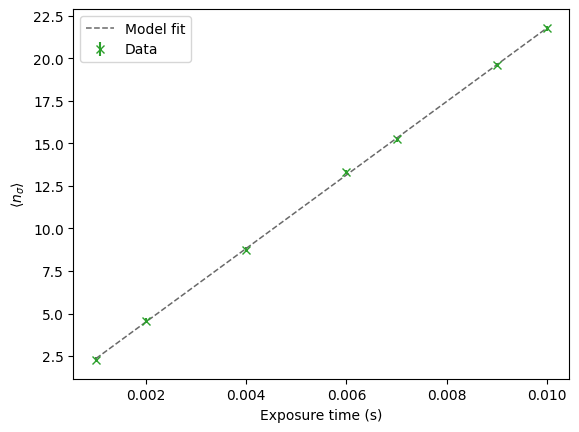

In [138]:
plt.errorbar(x, y, yerr=yerr, fmt='x', color='tab:green', markersize=6, label='Data')
plt.plot(x, res.params['slope'] * x + res.params['intercept'], color='dimgray', linestyle='dashed', linewidth=1.1, label='Model fit')
plt.xlabel('Exposure time (s)')
plt.ylabel(r'$\langle n_\sigma \rangle$')

# plt.xlim(0, 0.012)
# plt.ylim(0, 25)
plt.legend()
plt.savefig('Figures/sigval_vs_texp.png')

In [128]:
tt = 0.008
print(mod.eval(params=res.params, x=tt))
print(20*tt* np.sqrt(8000*24)/4)
print(20 * np.sqrt(8000*24)/4)

17.46163092665947
17.527121840165318
2190.8902300206646
